# Project_Notes_012

## Forecasting Renewable Energy Generation

**OBJECTIVE**  
The Objectives of this notebook is to Create Several Candidate High Performing Machine Learning Models To Predict Expected Delivery Time in Hours.



**WORKFLOW**  
The workflow is as follows:  
1. Data Loading And Understanding
2. Data Cleaning
3. Exploratory Data Analysis
4. Feature Engineering and Categorical Encoding
5. Feature Selection
6. Modelling and Models Selection
7. Hyperparameter Tuning
8. Ensembling Models
9. Deploying via Flask App

**DATA LOADING AND UNDERSTANDING**

In [61]:
# Import required packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gzip
from datetime import date
from datetime import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [2]:
# load the data.
df = pd.read_csv('./data/Project_Notes_011_renewable_data.csv')

In [3]:
# Check the shape of data.
df.shape

(131008, 12)

In [4]:
# Check the info of data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131008 entries, 0 to 131007
Data columns (total 12 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Delivery_ID                            131005 non-null  float64
 1   Delivery_Start_Date                    131007 non-null  object 
 2   Delivery_Start_Time                    131007 non-null  object 
 3   Traffic_Conditions                     131008 non-null  object 
 4   Number_of_Packages                     131006 non-null  float64
 5   Customer_Preference_for_Delivery_Time  131008 non-null  object 
 6   Distance_(miles)                       131007 non-null  float64
 7   fog                                    52244 non-null   object 
 8   rain                                   52269 non-null   object 
 9   snow                                   39180 non-null   object 
 10  hail                                   26231 non-null   

In [5]:
# Check the frst 10 rows of data.
df.head(10)

,Delivery_ID,Delivery_Start_Date,Delivery_Start_Time,Traffic_Conditions,Number_of_Packages,Customer_Preference_for_Delivery_Time,Distance_(miles),fog,rain,snow,hail,Historical_Delivery_Time_(hours)
0,1.0,2020-09-03,12:41:00,Low,7.0,Evening,167.884751,NaN,NaN,Low,NaN,9.294688
1,2.0,2022-12-22,20:14:00,Low,10.0,Morning,154.154474,Low,NaN,Mid,NaN,9.303765
2,3.0,2021-06-05,11:20:00,High,2.0,Afternoon,196.084835,NaN,Mid,NaN,NaN,8.734668
3,4.0,2023-05-02,05:50:00,High,15.0,Morning,94.010339,NaN,NaN,NaN,NaN,7.806979
4,5.0,2020-07-07,02:34:00,Moderate,17.0,Evening,202.254271,Mid,NaN,NaN,NaN,12.770403
5,6.0,2021-01-08,06:46:00,High,7.0,Evening,142.464202,NaN,Low,NaN,NaN,6.731095
6,7.0,2021-11-02,05:25:00,Low,17.0,Afternoon,193.844452,NaN,Mid,NaN,NaN,9.108041
7,8.0,2022-03-01,16:44:00,High,6.0,Evening,145.056879,NaN,NaN,NaN,NaN,5.977140
8,9.0,2023-02-15,18:46:00,High,18.0,Evening,155.081309,NaN,Mid,NaN,NaN,7.241487
9,10.0,2021-09-16,22:31:00,Low,1.0,Evening,137.508941,NaN,Low,NaN,NaN,3.718040


In [6]:
# Define a dictionary to rename some columns.
col_dict = {
            'Delivery_ID': 'id', 
            'Delivery_Start_Date': 'start_date', 
            'Delivery_Start_Time': 'start_time', 
            'Traffic_Conditions': 'traffic', 
            'Number_of_Packages': 'packages',  
            'Customer_Preference_for_Delivery_Time': 'preference', 
            'Distance_(miles)': 'distance', 
            'Historical_Delivery_Time_(hours)': 'delivery'
           }

In [7]:
# Rename the required columns.
df = df.rename(columns=col_dict)

In [8]:
# Check a few rows of df.
df.head()

,id,start_date,start_time,traffic,packages,preference,distance,fog,rain,snow,hail,delivery
0,1.0,2020-09-03,12:41:00,Low,7.0,Evening,167.884751,NaN,NaN,Low,NaN,9.294688
1,2.0,2022-12-22,20:14:00,Low,10.0,Morning,154.154474,Low,NaN,Mid,NaN,9.303765
2,3.0,2021-06-05,11:20:00,High,2.0,Afternoon,196.084835,NaN,Mid,NaN,NaN,8.734668
3,4.0,2023-05-02,05:50:00,High,15.0,Morning,94.010339,NaN,NaN,NaN,NaN,7.806979
4,5.0,2020-07-07,02:34:00,Moderate,17.0,Evening,202.254271,Mid,NaN,NaN,NaN,12.770403


**DATA CLEANING**

In [9]:
# Check for duplicates.
df.duplicated().sum()

8

In [10]:
# Remove duplicates.
df.drop_duplicates(inplace=True)

In [11]:
# Check the shape of df.
df.shape

(131000, 12)

In [12]:
# Check for mising values.
df.isna().sum()

id                 3
start_date         1
start_time         1
traffic            0
packages           2
preference         0
distance           1
fog            78762
rain           78735
snow           91820
hail          104771
delivery           1
dtype: int64

In [13]:
# Calculate the percentage of missing values in each column.
miss_val = df.isna().sum()
miss_ind = miss_val.index.to_list()

for x in range(len(miss_val)):
    print(f'Percentage missing in {miss_ind[x]} is: {int(miss_val.iloc[x]/131000 * 100)}%')

Percentage missing in id is: 0%
Percentage missing in start_date is: 0%
Percentage missing in start_time is: 0%
Percentage missing in traffic is: 0%
Percentage missing in packages is: 0%
Percentage missing in preference is: 0%
Percentage missing in distance is: 0%
Percentage missing in fog is: 60%
Percentage missing in rain is: 60%
Percentage missing in snow is: 70%
Percentage missing in hail is: 79%
Percentage missing in delivery is: 0%


The 'id', 'fog', 'rain', 'snow' and 'hail' columns will be deleted.

In [14]:
# Drop columns not needed.
drop_cols = ['id', 'fog', 'rain', 'snow', 'hail']
df.drop(columns=drop_cols, axis=1, inplace=True)

In [15]:
# Check a few rows of df.
df.head()

,start_date,start_time,traffic,packages,preference,distance,delivery
0,2020-09-03,12:41:00,Low,7.0,Evening,167.884751,9.294688
1,2022-12-22,20:14:00,Low,10.0,Morning,154.154474,9.303765
2,2021-06-05,11:20:00,High,2.0,Afternoon,196.084835,8.734668
3,2023-05-02,05:50:00,High,15.0,Morning,94.010339,7.806979
4,2020-07-07,02:34:00,Moderate,17.0,Evening,202.254271,12.770403


In [16]:
# Drop other missing values.
df.dropna(inplace=True)

In [17]:
# Check the shape of df.
df.shape

(130994, 7)

**EXPLORATORY DATA ANALYSIS:** Observe the relationships between the columns and the target variables

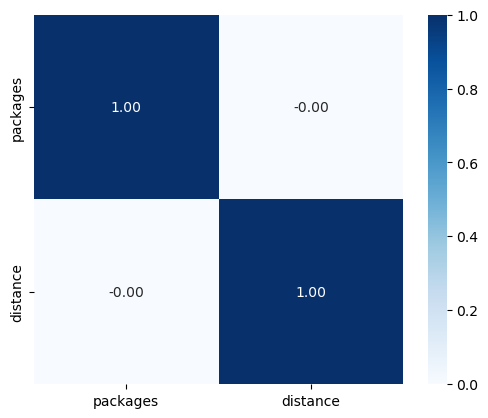

In [21]:
# Create a correlation heatmap.
corr_df = df.select_dtypes(include='number')\
            .drop('delivery', axis=1)\
            .corr()

sns.heatmap(corr_df,
            cbar=True,
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'size': 10},
            cmap="Blues")

plt.show()

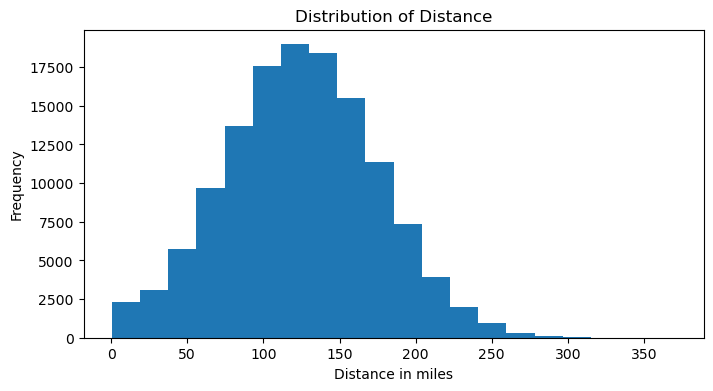

In [22]:
# Plot distribution of distance.
plt.figure(figsize=(8, 4))
df['distance'].plot(kind='hist', bins=20)
plt.title(f'Distribution of Distance')
plt.xlabel('Distance in miles')
plt.ylabel('Frequency')
plt.show()

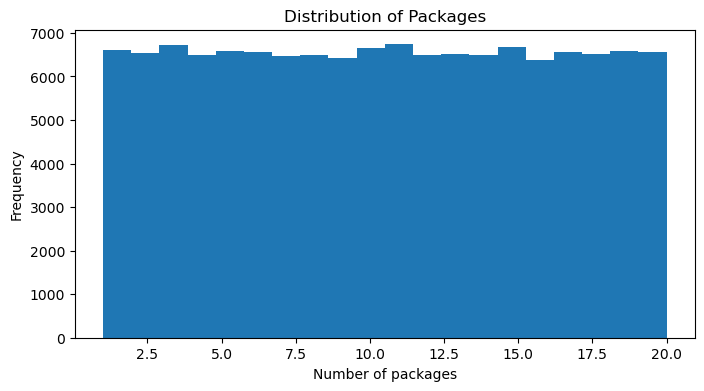

In [23]:
# Plot distribution of packages.
plt.figure(figsize=(8, 4))
df['packages'].plot(kind='hist', bins=20)
plt.title(f'Distribution of Packages')
plt.xlabel('Number of packages')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Function to create categorical count plot.
def create_count_plot(col):
  plt.figure(figsize=(8, 4))
  df[col].value_counts().plot(kind='bar')
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.show()

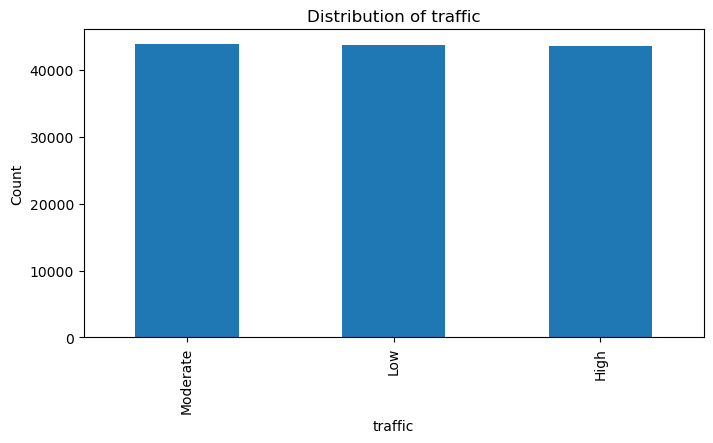

In [25]:
# Show count plot for traffic.
create_count_plot("traffic")

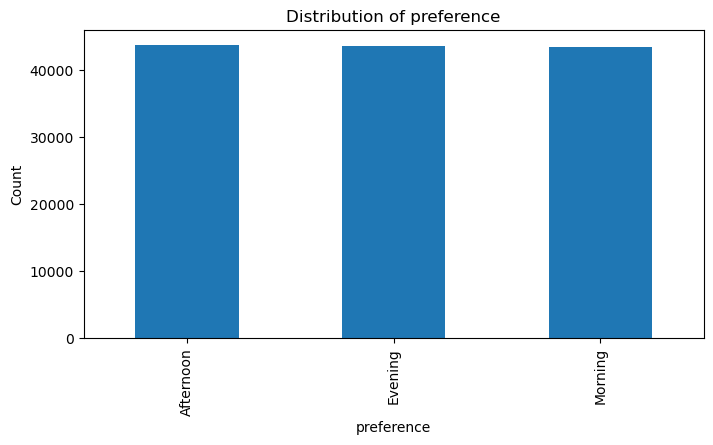

In [26]:
# Show count plot for customer_preference.
create_count_plot("preference")

**FEATURE ENGINEERING**

In [27]:
# Split the start_date column to year, month and day columns.
df['year'] = [int(pd.to_datetime(x).year) for x in df['start_date']]
df['month'] = [int(pd.to_datetime(x).month) for x in df['start_date']]
df['day'] = [int(pd.to_datetime(x).day) for x in df['start_date']]

In [28]:
# Split the start_time column to hour, minute and second columns.
df['hour'] = [int(pd.to_datetime(x).hour) for x in df['start_time']]
df['minute'] = [int(pd.to_datetime(x).minute) for x in df['start_time']]
df['second'] = [int(pd.to_datetime(x).second) for x in df['start_time']]

In [29]:
# Drop the start_date and start_time columns after spliting.
df.drop(columns=['start_date', 'start_time'], axis=1, inplace=True)

In [30]:
# Check a few rows of df.
df.head()

,traffic,packages,preference,distance,delivery,year,month,day,hour,minute,second
0,Low,7,Evening,167.884751,9.294688,2020,9,3,12,41,0
1,Low,10,Morning,154.154474,9.303765,2022,12,22,20,14,0
2,High,2,Afternoon,196.084835,8.734668,2021,6,5,11,20,0
3,High,15,Morning,94.010339,7.806979,2023,5,2,5,50,0
4,Moderate,17,Evening,202.254271,12.770403,2020,7,7,2,34,0


In [31]:
# Sum the values in the second column
df['second'].sum()

0

In [32]:
# Remove the second column.
df.drop(columns='second', axis=1, inplace=True)

In [33]:
# Convert the packages column to integer.
df['packages'] = df['packages'].astype('int64')

In [34]:
# Check the info of df.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130994 entries, 0 to 130999
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   traffic     130994 non-null  object 
 1   packages    130994 non-null  int64  
 2   preference  130994 non-null  object 
 3   distance    130994 non-null  float64
 4   delivery    130994 non-null  float64
 5   year        130994 non-null  int64  
 6   month       130994 non-null  int64  
 7   day         130994 non-null  int64  
 8   hour        130994 non-null  int64  
 9   minute      130994 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 11.0+ MB


In [35]:
# Ckeck the unique values of the traffic column.
df['traffic'].unique()

array(['Low', 'High', 'Moderate'], dtype=object)

In [36]:
# Ckeck the unique values of the customer_preference column.
df['preference'].unique()

array(['Evening', 'Morning', 'Afternoon'], dtype=object)

In [37]:
# Create Numerical masks for the traffic and customer_preference columns.
mask_traffic = {'Low': 1, 'High': 2, 'Moderate': 3}
mask_preference = {'Evening': 1, 'Morning': 2, 'Afternoon': 3}

In [46]:
# Apply the masks.
df['traffic'] = df['traffic'].map(mask_traffic)
df['preference'] = df['preference'].map(mask_preference)

In [47]:
# Rearrange df.
df = df[['traffic', 'packages', 'preference', 'distance',
        'year', 'month', 'day', 'hour', 'minute', 'delivery']]

In [48]:
# Check a few rows of df.
df.head()

,traffic,packages,preference,distance,year,month,day,hour,minute,delivery
0,1,7,1,167.884751,2020,9,3,12,41,9.294688
1,1,10,2,154.154474,2022,12,22,20,14,9.303765
2,2,2,3,196.084835,2021,6,5,11,20,8.734668
3,2,15,2,94.010339,2023,5,2,5,50,7.806979
4,3,17,1,202.254271,2020,7,7,2,34,12.770403


**CREATE TRAINING AND TEST SET**

In [51]:
# Define the features and target.
features = ['traffic', 'packages', 'preference', 'distance',
            'year', 'month', 'day', 'hour', 'minute']

target = 'delivery'

**MODELING AND SELECTION**  
Train models from tree based/ensemble

In [ ]:
# Define X and y.
X = df[features]
y = df[target]

In [52]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models.
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Training and evaluation loop.
for model_name, model in models.items():
    
    # Train the model.
    model.fit(X_train, y_train)

    # Make predictions.
    y_pred = model.predict(X_test)

    # Calculate RMSE, MAE, and MAPE.
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE in percentage

    # Print the results.
    print(f"Model: {model_name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("=" * 40)

Model: Decision Tree
RMSE: 2.78
MAE: 2.19
MAPE: 30.13%
Model: Random Forest
RMSE: 1.98
MAE: 1.58
MAPE: 22.18%
Model: Gradient Boosting
RMSE: 1.91
MAE: 1.53
MAPE: 21.41%


Neigbours

In [56]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN regressor models with different values of k.
k_values = [1, 3, 5, 7, 9]  # You can adjust these values
models = {f"KNN (k={k})": KNeighborsRegressor(n_neighbors=k) for k in k_values}

# Training and evaluation loop.
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions.
    y_pred = model.predict(X_test)

    # Calculate RMSE, MAE, and MAPE.
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE in percentage

    # Print the results.
    print(f"Model: {model_name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("=" * 40)

Model: KNN (k=1)
RMSE: 3.05
MAE: 2.40
MAPE: 33.39%
Model: KNN (k=3)
RMSE: 2.48
MAE: 1.96
MAPE: 27.62%
Model: KNN (k=5)
RMSE: 2.35
MAE: 1.86
MAPE: 26.37%
Model: KNN (k=7)
RMSE: 2.30
MAE: 1.82
MAPE: 25.80%
Model: KNN (k=9)
RMSE: 2.27
MAE: 1.79
MAPE: 25.45%


Linear models

In [54]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear models.
linear_regressor = LinearRegression()
lasso_regressor = Lasso(alpha=1.0)
ridge_regressor = Ridge(alpha=1.0)
elasticnet_regressor = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Create a dictionary of models.
models = {
    "Linear Regression": linear_regressor,
    "Lasso Regression": lasso_regressor,
    "Ridge Regression": ridge_regressor,
    "Elastic Net": elasticnet_regressor
}

# Training and evaluation loop for each model.
for model_name, model in models.items():
    
    # Train the model.
    model.fit(X_train, y_train)

    # Make predictions.
    y_pred = model.predict(X_test)

    # Calculate RMSE, MAE, and MAPE.
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE in percentage

    # Print the results.
    print(f"Model: {model_name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("=" * 40)

Model: Linear Regression
RMSE: 2.16
MAE: 1.72
MAPE: 24.33%
Model: Lasso Regression
RMSE: 2.21
MAE: 1.76
MAPE: 25.27%
Model: Ridge Regression
RMSE: 2.16
MAE: 1.72
MAPE: 24.33%
Model: Elastic Net
RMSE: 2.19
MAE: 1.74
MAPE: 24.99%


The top performing models are : Random Forest, Gradient Boosting and KNN

**HYPERPARAMETER TUNING USING GRID SEARCH**

Imporoving Random Forest Using Grid serach

In [58]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor.
rf_regressor = RandomForestRegressor(random_state=42)

# Define the hyperparameters and their possible values for the grid search.
param_grid = {
    'n_estimators': [100],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [ 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [ 2, 4],   # Minimum number of samples required at each leaf node
}

# Create the grid search.
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

# Perform the grid search on the training data.
grid_search.fit(X_train, y_train)

# Get the best model from the grid search.
best_rf_model = grid_search.best_estimator_

# Make predictions.
y_pred = best_rf_model.predict(X_test)

# Calculate RMSE and MAE.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and evaluation metrics.
print("Best Hyperparameters:")
print(grid_search.best_params_)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
RMSE: 1.94
MAE: 1.55


Impoving Gradient Boosting Regressor Using Grid serach

In [59]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Gradient Boosting Regressor.
gb_regressor = GradientBoostingRegressor(random_state=42)

# Define the hyperparameters and their possible values for the grid search.
param_grid = {
    'n_estimators': [100],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 4, 5],  # Maximum depth of individual trees
}

# Create the grid search.
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

# Perform the grid search on the training data.
grid_search.fit(X_train, y_train)

# Get the best model from the grid search.
best_gb_model = grid_search.best_estimator_

# Make predictions.
y_pred = best_gb_model.predict(X_test)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and evaluation metrics.
print("Best Hyperparameters:")
print(grid_search.best_params_)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
RMSE: 1.91
MAE: 1.53


Impoving K nerest Neighbor Regressor Using Grid serach

In [60]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN Regressor.
knn_regressor = KNeighborsRegressor()

# Define the hyperparameters and their possible values for the grid search.
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting strategy for neighbors
}

# Create the grid search.
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

# Perform the grid search on the training data.
grid_search.fit(X_train, y_train)

# Get the best model from the grid search.
best_knn_model = grid_search.best_estimator_

# Make predictions.
y_pred = best_knn_model.predict(X_test)

# Calculate RMSE and MAE.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and evaluation metrics.
print("Best Hyperparameters:")
print(grid_search.best_params_)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters:
{'n_neighbors': 11, 'weights': 'distance'}
RMSE: 2.25
MAE: 1.78


In [63]:
# Get final RandomForestRegressor model.
final_rf = RandomForestRegressor(n_estimators=100,max_depth=20, min_samples_leaf= 4, min_samples_split=10)
final_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10)

In [64]:
# Get final GradientBoostingRegressor model.
final_gb = GradientBoostingRegressor(learning_rate=0.2, max_depth=3, n_estimators=100)
final_gb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2)

In [65]:
# Get final KNeighborsRegressor model.
final_knn = KNeighborsRegressor(n_neighbors=11, weights="distance")
final_knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=11, weights='distance')

**ENSEMBLING MODELS: STACKING VS AVERAGING**  
STACKING

In [66]:
# Initialize the base models.
final_rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=4, min_samples_split=10)
final_gb = GradientBoostingRegressor(learning_rate=0.2, max_depth=3, n_estimators=100)
final_knn = KNeighborsRegressor(n_neighbors=11, weights="distance")

# Create a list of base models.
base_models = [('KNN', final_knn), ('GBR', final_gb), ('RFR', final_rf)]

# Initialize the meta-model (Linear Regression in this case).
meta_model = LinearRegression()

# Create the stacking ensemble
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stacking ensemble to the data.
stacking_regressor.fit(X_train, y_train)

# Make predictions.
y_pred = stacking_regressor.predict(X_test)

# Evaluate the ensemble.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Stacking Ensemble RMSE: {rmse:.2f}")
print(f"Stacking Ensemble MAE: {mae:.2f}")

Stacking Ensemble RMSE: 1.91
Stacking Ensemble MAE: 1.53


AVERAGING

In [68]:
# Initialize the base models.
final_rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf= 4, min_samples_split=10)
final_gb = GradientBoostingRegressor(learning_rate=0.2, max_depth=3, n_estimators=100)
final_knn = KNeighborsRegressor(n_neighbors=11, weights="distance")

# Create a list of base models.
base_models = [('KNN', final_knn), ('GBR', final_gb), ('RFR', final_rf)]

# Initialize the ensemble (VotingRegressor with averaging).
ensemble_regressor = VotingRegressor(estimators=base_models)

# Fit the ensemble to the data.
ensemble_regressor.fit(X_train, y_train)

# Make predictions.
y_pred = ensemble_regressor.predict(X_test)

# Evaluate the ensemble.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Averaging Ensemble RMSE: {rmse:.2f}")
print(f"Averaging Ensemble MAE: {mae:.2f}")

Averaging Ensemble RMSE: 1.96
Averaging Ensemble MAE: 1.57


**USE THE MODEL FOR SOME PREDICTIONS**

In [71]:
# Save the stacking_regressor model.
pickle.dump(stacking_regressor, gzip.open('./data/Project_Notes_011_renewable_model.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [72]:
# load the the stacking_regressor model.
loaded_model = pickle.load(gzip.open('./data/Project_Notes_011_renewable_model.pkl', 'rb'))

In [73]:
# Create function to predict the raw data
def predict_data(raw_data):
    data_frame = pd.DataFrame(raw_data, index=[0])
    data_predict = loaded_model.predict(data_frame)
    return data_predict[0]

In [109]:
# Get the sample data to use.
sample_data = df.iloc[2120]
sample_data

traffic          1.000000
packages         2.000000
preference       2.000000
distance       133.539599
year          2020.000000
month            3.000000
day              7.000000
hour            10.000000
minute           5.000000
delivery         4.738282
Name: 2120, dtype: float64

In [110]:
raw_data = {
            "traffic": sample_data.iloc[0],
            "packages": sample_data.iloc[1],
            "preference": sample_data.iloc[2],
            "distance": sample_data.iloc[3],
            "year": sample_data.iloc[4],
            "month": sample_data.iloc[5],
            "day": sample_data.iloc[6],
            "hour": sample_data.iloc[7],
            "minute": sample_data.iloc[8]
            }

raw_data

{'traffic': 1.0,
 'packages': 2.0,
 'preference': 2.0,
 'distance': 133.53959872358544,
 'year': 2020.0,
 'month': 3.0,
 'day': 7.0,
 'hour': 10.0,
 'minute': 5.0}

In [111]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

5.394793007171949

In [121]:
# Get the sample data to use.
sample_data = df.iloc[4132]
sample_data

traffic          1.000000
packages        16.000000
preference       2.000000
distance       150.688004
year          2020.000000
month            9.000000
day              5.000000
hour             6.000000
minute           6.000000
delivery         5.739895
Name: 4132, dtype: float64

In [122]:
raw_data = {
            "traffic": sample_data.iloc[0],
            "packages": sample_data.iloc[1],
            "preference": sample_data.iloc[2],
            "distance": sample_data.iloc[3],
            "year": sample_data.iloc[4],
            "month": sample_data.iloc[5],
            "day": sample_data.iloc[6],
            "hour": sample_data.iloc[7],
            "minute": sample_data.iloc[8]
            }

raw_data

{'traffic': 1.0,
 'packages': 16.0,
 'preference': 2.0,
 'distance': 150.6880038974703,
 'year': 2020.0,
 'month': 9.0,
 'day': 5.0,
 'hour': 6.0,
 'minute': 6.0}

In [123]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

8.163452305184677

In [124]:
# Get the sample data to use.
sample_data = df.iloc[9065]
sample_data

traffic          3.000000
packages        20.000000
preference       2.000000
distance        21.211363
year          2020.000000
month           12.000000
day             12.000000
hour             9.000000
minute          13.000000
delivery         5.892630
Name: 9066, dtype: float64

In [125]:
raw_data = {
            "traffic": sample_data.iloc[0],
            "packages": sample_data.iloc[1],
            "preference": sample_data.iloc[2],
            "distance": sample_data.iloc[3],
            "year": sample_data.iloc[4],
            "month": sample_data.iloc[5],
            "day": sample_data.iloc[6],
            "hour": sample_data.iloc[7],
            "minute": sample_data.iloc[8]
            }

raw_data

{'traffic': 3.0,
 'packages': 20.0,
 'preference': 2.0,
 'distance': 21.211363411110767,
 'year': 2020.0,
 'month': 12.0,
 'day': 12.0,
 'hour': 9.0,
 'minute': 13.0}

In [126]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

7.05846177786543